## Plot the regional time evolution of total column ozone

In this exercise you will read-in various total column ozone (TCO) datasets from a variety of sources:

1. Observations from Bodeker Scientific
2. Processed UKCA data submitted to phase 1 of the Chemistry-Climate Model Initative (CCMI1)
3. A ensemble of processed UKCA submitted to CCMI2022
4. UM-UKCA pp-file output run as part of the NERC ACSIS project

Some example plots will be given, along with suggested exercises for you to complete.

In [1]:
import iris
import iris.util
import iris.analysis
import iris.coord_categorisation
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
from iris.time import PartialDateTime
import cf_units

In [2]:
# define the locations of the various datasets
# CCMI2022 refD1 ensemble
ensdata='/home/ubuntu/Tutorials/UMvn13.0/data/toz_Amon_UKESM1-StratTrop_refD1_r?i1p1f2_gn_19600101-20190101.nc'
# CCMI1 refC1
ccmidata='/home/ubuntu/Tutorials/UMvn13.0/data/toz_monthly_UMUKCA-UCAM_refC1_r1i1p1_*.nc'
# UKCA model data from ACSIS project, nudged to ERA5
ukcadata='/home/ubuntu/Tutorials/UMvn13.0/data/u-*/apm.pp/*.pp'
# Bodeker Scientific TCO dataset - https://www.bodekerscientific.com/data/total-column-ozone
# this has been preprocessed into a single file using ncks, ncatted, and ncrcat
# for i in `ls *.nc`; do echo $i; ncks -O --mk_rec_dmn time $i $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a created,global,d,, $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a units,longitude,o,c,degrees_east $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a units,latitude,o,c,degrees_north $i; done
# ncrcat BSFilledTCO_V3.4.1_????_Monthly.nc ../BSFilledTCO_V3.4.1_Monthly.nc
obsdata='/home/ubuntu/Tutorials/UMvn13.0/data/Bodeker_3.4.1/*.nc'
# We would like to thank Bodeker Scientific, funded by the New Zealand Deep South National 
# Science Challenge, for providing the combined NIWA-BS total column ozone database.

In [3]:
# CCMI2022 data is in units of m rather than Dobson units, so will need to convert later
duconv=1.0e5

In [4]:
# read-in the data
# 3x ensemble members for CCMI2022
inens=iris.load(ensdata,'toz')

# 10-year files for CCMI1, need to remove differing attributes
inccmi=iris.load(ccmidata,'toz')
attrs=iris.util.equalise_attributes(inccmi)
# concatinate in time
ccmi=inccmi.concatenate_cube()

# pp-files for UKCA, individual files
ukca=iris.load_cube(ukcadata,iris.AttributeConstraint(STASH='m01s50i219'))

# Bodeker Total Column Ozone dataset - **preprocessed**
obs=iris.load_cube(obsdata,'equivalent_thickness_at_stp_of_atmosphere_ozone_content')

/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'toz'
  warnings.warn(
/tmp/ipykernel_13795/1800724441.py:3: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  inens=iris.load(ensdata,'toz')
/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'toz'
  warnings.warn(
/tmp/ipykernel_13795/1800724441.py:3: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  inens=iris.load(ensdata,'toz')
/home/ubuntu/miniconda3/lib/python

In [5]:
# regularise the time units to enable plotting correctly
unit=cf_units.Unit('days since 1960-01-01', calendar='360_day')
for cube in inens:
    cube.coord('time').convert_units(unit)
    
ccmi.coord('time').convert_units(unit)

# these are Gregorian calendar, do a rough conversion
# Obs
obs.coord('time').points=obs.coord('time').points*(360.0/365.24)
obs.coord('time').units=unit=cf_units.Unit(str(obs.coord('time').units), calendar='360_day')
obs.coord('time').convert_units(unit)
# nudged data
ukca.coord('time').points=ukca.coord('time').points*(360.0/365.24)
ukca.coord('time').units=unit=cf_units.Unit(str(ukca.coord('time').units), calendar='360_day')
ukca.coord('time').convert_units(unit)

In [6]:
# function to calculate means over latitude bands
def mask_region_mean(incube,lower_lat=-60.0,higher_lat=60.0):
    cube=incube.copy()
    if not cube.coord('latitude').has_bounds():
        cube.coord('latitude').guess_bounds()
    if not cube.coord('longitude').has_bounds():
        cube.coord('longitude').guess_bounds()

    cube_grid_areas = iris.analysis.cartography.area_weights(cube)
    for i in range(cube.coord('latitude').points.shape[0]):
        if cube.coord('latitude').points[i] < lower_lat or cube.coord('latitude').points[i] > higher_lat:
            # total column ozone is 3D field, T,Y,X
            cube_grid_areas[:,i,:] = 0.0
    cube_mean = cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN, weights = cube_grid_areas)
            
    return cube_mean
    del cube
    del cube_mean

In [7]:
# extract only September dates
imonth=9
# consider south polar region - 90S to 60S
llat=-90.0
hlat=-60.0

month_range = iris.Constraint(
    time=lambda cell: PartialDateTime(month=imonth, day=1) <= cell.point < PartialDateTime(month=imonth, day=31))

# mask off, selecting only the north pole values
# ensemble mean from CCMI2022
ens=iris.cube.CubeList()
for cube in inens:
    cube=mask_region_mean(cube,lower_lat=llat,higher_lat=hlat)
    cube=cube.extract(month_range)
    # add months as a auxillary coordinate
    iris.coord_categorisation.add_month_fullname(cube,'time')
    # convert to DU for this set of data
    cube.data=cube.data/duconv
    cube.units='DU'
    ens.append(cube)
    
# CCMI1
ccmi=mask_region_mean(ccmi,lower_lat=llat,higher_lat=hlat)
ccmi=ccmi.extract(month_range)
# add months as a auxillary coordinate
iris.coord_categorisation.add_month_fullname(ccmi,'time')

# Obs
obs=mask_region_mean(obs,lower_lat=llat,higher_lat=hlat)
obs=obs.extract(month_range)
# add months as a auxillary coordinate
iris.coord_categorisation.add_month_fullname(obs,'time')

# UKCA pp files
ukca=mask_region_mean(ukca,lower_lat=llat,higher_lat=hlat)
ukca=ukca.extract(month_range)
# add months as a auxillary coordinate
iris.coord_categorisation.add_month_fullname(ukca,'time')

/home/ubuntu/miniconda3/lib/python3.9/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [8]:
# calculate ensemble mean and standard deviation
arr=np.zeros((len(ens[0].data),len(ens),))
for i in range(len(ens)):
    arr[:,i]=ens[i].data[:]
darr=np.mean(arr,axis=1)
dstd=np.std(arr,axis=1)
# give error envelope as 2 standard error (2.0*std/sqrt(ensemble size))
dstderr=2.0*dstd/np.sqrt(len(ens))
# save to a cube for plotting
ensmean=ens[0].copy()
ensmean.data=darr

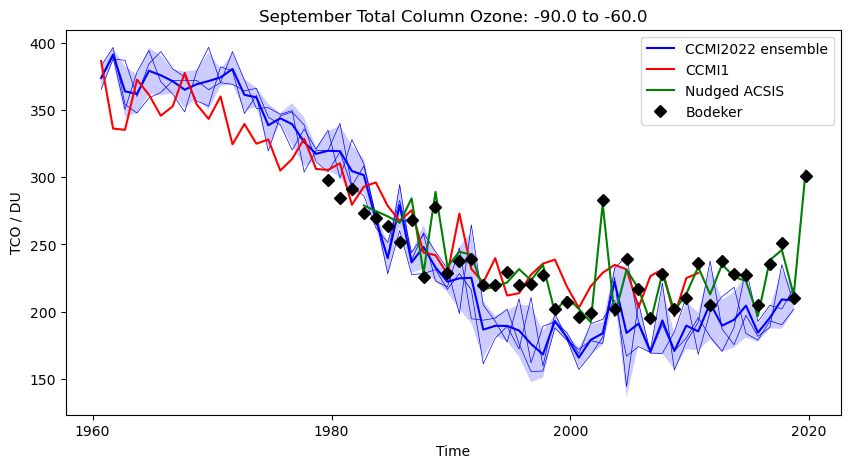

In [9]:
# Now plot the data

# make the plot a bit wider
plt.figure(figsize=(10,5))

# CCMI2022 ensemble
# plot the ensemble member lines for reference
for cube in ens:
    qplt.plot(cube,color='b',linewidth=0.5)
# plot the ensemble mean
qplt.plot(ensmean,color='b',linewidth=1.5, label='CCMI2022 ensemble')
# plot 2x standard error as a shaded envelope
qplt.fill_between(ensmean.coord('time'),ensmean-dstderr,ensmean+dstderr, alpha=0.2, color='b', edgecolor=None)

# CCMI1 REF-C1
qplt.plot(ccmi,color='r', label='CCMI1')

# Nudged ACSIS UKCA run
qplt.plot(ukca,color='g', label='Nudged ACSIS')

# Bodeker observations
qplt.plot(obs,color='k',marker='D',linestyle='none', label='Bodeker')

# plot title with some descriptive information
plt.title(ensmean.coord('month_fullname').points[imonth]+' Total Column Ozone: '+str(llat)+' to '+str(hlat))
plt.ylabel('TCO / DU')
# include legend
plt.legend()
plt.show()

### Further exercises to try:

1. Try plotting different months and regions, e.g. March for 60N to 90N
2. Try plotting annual mean TCO from 60S to 60N. How would you go about producing an annual mean of each year?


<details>
<summary>Hint: </summary>
Take a look at the <a href="https://scitools-iris.readthedocs.io/en/stable/generated/api/iris/cube.html#iris.cube.Cube.aggregated_by">aggregated_by() method in Iris</a>.
</details>